# Assignment 3 - Network biology (deadline: 26-09)

### Building on the Boolean Networks practical, you will conduct an independent analysis of cancer-causing mutations using Boolean networks.

In [2]:
# 🟢 Setup and Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import seaborn as sns
from itertools import product
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

### Helper functions to create a Boolean network
Run the following code snippet so the basic functions are available.

In [3]:
# 🟢 Helper class to build and simulate boolean network

class BooleanNetwork:
    def __init__(self, node_names):
        self.nodes = {name: 0 for name in node_names}
        self.rules = {}
        self.history = []
        self.graph = nx.DiGraph()  # NetworkX graph for visualization

        # Add nodes to NetworkX graph
        self.graph.add_nodes_from(node_names)

    def add_rule(self, target_node, rule_function, rule_description=""):
        """
        Add Boolean rule for a node

        Args:
            target_node: Node to update
            rule_function: Function that takes current state dict and returns True/False
            rule_description: Human-readable description
        """
        self.rules[target_node] = {
            'function': rule_function,
            'description': rule_description
        }

    def set_state(self, **kwargs):
        """Set states of specific nodes"""
        for node, value in kwargs.items():
            if node in self.nodes:
                self.nodes[node] = int(bool(value))

    def get_state_vector(self):
        """Get current state as list in sorted order"""
        return [self.nodes[node] for node in sorted(self.nodes.keys())]

    def update_synchronous(self):
        """Update all nodes simultaneously"""
        new_state = {}
        for node in self.nodes:
            if node in self.rules:
                new_state[node] = int(self.rules[node]['function'](self.nodes))
            else:
                new_state[node] = self.nodes[node]  # No rule = no change

        self.nodes = new_state
        self.history.append(self.get_state_vector())

    def simulate(self, steps=10, record_history=True):
        """Run simulation"""
        if record_history:
            self.history = [self.get_state_vector()]

        for step in range(steps):
            self.update_synchronous()

            # Check for steady state
            if len(self.history) >= 2 and self.history[-1] == self.history[-2]:
                print(f"   Reached steady state after {step+1} steps")
                break

        return np.array(self.history)

# Create 4 different mutated versions of the cell regulatory network by modifying the Boolean rules:
* Mutation A: p53 Knockout (Loss of tumor suppressor):   network.add_rule('p53', lambda s: False, "p53 = BROKEN (always OFF)")
* Mutation B: MYC Amplification (Oncogene overexpression):   network.add_rule('MYC', lambda s: True, "MYC = AMPLIFIED (always ON)")
* Mutation C: MDM2 Overexpression (p53 pathway disruption):   network.add_rule('MDM2', lambda s: True, "MDM2 = OVEREXPRESSED (always ON)")
* Mutation D: Your Choice (Design your own mutation)

- - - - - - 

Normal cell regulatory network

🧬 Biological context

Cells make binary decisions:
* GROW: Divide and multiply (good for healing, bad if uncontrolled)
* DIE: Self-destruct (protective mechanism, prevents cancer)
* REST: Stay inactive (safe default state)

Key molecular switches (think: binary variables):
* DNA_damage: External damage signal (input variable)
* p53: "Tumor suppressor" - master safety switch that detects problems
* MYC: "Oncogene" - growth promoter that drives cell division
* CDK2: Cell division machinery that executes growth
* MDM2: "p53 inhibitor" - blocks p53 function (cancer exploit!)
* p21: "Cell cycle brake" - stops division when problems detected
* Growth/Death: Final binary decisions (outputs)

In [4]:
# 🟢 Create the regulatory network
nodes = ['DNA_damage', 'p53', 'MYC', 'CDK2', 'MDM2', 'p21', 'Growth', 'Death']
networkNormal = BooleanNetwork(nodes)

# Define Boolean rules (based on real biology, simplified)
networkNormal.add_rule('DNA_damage', lambda s: s['DNA_damage'], "DNA_damage = INPUT (constant)")
networkNormal.add_rule('p21', lambda s: s['p53'], "p21 = p53")
networkNormal.add_rule('MYC', lambda s: (not s['p53']) and (not s['p21']), "MYC = (NOT p53) AND (NOT p21)")
networkNormal.add_rule('CDK2', lambda s: s['MYC'] and (not s['p21']) and (not s['p53']), "CDK2 = MYC AND (NOT p21) AND (NOT p53)")
networkNormal.add_rule('MDM2', lambda s: s['MYC'], "MDM2 = MYC")
networkNormal.add_rule('p53', lambda s: s['DNA_damage'] and not s['MDM2'], "p53 = DNA_damage AND (NOT MDM2)")
networkNormal.add_rule('Growth',lambda s: s['CDK2'] and s['MYC'] and (not s['p53']), "Growth = CDK2 AND MYC AND (NOT p53)")
networkNormal.add_rule('Death', lambda s: s['p53'] and s['DNA_damage'] and (not s['Growth']), "Death = p53 AND DNA_damage AND (NOT Growth)")

print("Rules:")
for node, rule_info in networkNormal.rules.items():
    print(f" {rule_info['description']}")

Rules:
 DNA_damage = INPUT (constant)
 p21 = p53
 MYC = (NOT p53) AND (NOT p21)
 CDK2 = MYC AND (NOT p21) AND (NOT p53)
 MDM2 = MYC
 p53 = DNA_damage AND (NOT MDM2)
 Growth = CDK2 AND MYC AND (NOT p53)
 Death = p53 AND DNA_damage AND (NOT Growth)


- - - - - - 

Mutation A cell regulatory network

🧬 Biological context

Cells make binary decisions:
* GROW: Divide and multiply (good for healing, bad if uncontrolled)
* DIE: Self-destruct (protective mechanism, prevents cancer)
* REST: Stay inactive (safe default state)

Key molecular switches (think: binary variables):
* Mutation A: p53 Knockout (Loss of tumor suppressor)
* DNA_damage: External damage signal (input variable)
* p53: "Tumor suppressor" - master safety switch that detects problems
* MYC: "Oncogene" - growth promoter that drives cell division
* CDK2: Cell division machinery that executes growth
* MDM2: "p53 inhibitor" - blocks p53 function (cancer exploit!)
* p21: "Cell cycle brake" - stops division when problems detected
* Growth/Death: Final binary decisions (outputs)

In [5]:
nodes = ['DNA_damage', 'p53', 'MYC', 'CDK2', 'MDM2', 'p21', 'Growth', 'Death']
networkMutationA = BooleanNetwork(nodes)

# Define Boolean rules (based on real biology, simplified)
networkMutationA.add_rule('DNA_damage', lambda s: s['DNA_damage'], "DNA_damage = INPUT (constant)")
networkMutationA.add_rule('p21', lambda s: s['p53'], "p21 = p53")
networkMutationA.add_rule('MYC', lambda s: (not s['p53']) and (not s['p21']), "MYC = (NOT p53) AND (NOT p21)")
networkMutationA.add_rule('CDK2', lambda s: s['MYC'] and (not s['p21']) and (not s['p53']), "CDK2 = MYC AND (NOT p21) AND (NOT p53)")
networkMutationA.add_rule('MDM2', lambda s: s['MYC'], "MDM2 = MYC")
networkMutationA.add_rule('p53', lambda s: False, "p53 = BROKEN (always OFF)")
networkMutationA.add_rule('Growth',lambda s: s['CDK2'] and s['MYC'] and (not s['p53']), "Growth = CDK2 AND MYC AND (NOT p53)")
networkMutationA.add_rule('Death', lambda s: s['p53'] and s['DNA_damage'] and (not s['Growth']), "Death = p53 AND DNA_damage AND (NOT Growth)")

print("Rules:")
for node, rule_info in networkMutationA.rules.items():
    print(f" {rule_info['description']}")

Rules:
 DNA_damage = INPUT (constant)
 p21 = p53
 MYC = (NOT p53) AND (NOT p21)
 CDK2 = MYC AND (NOT p21) AND (NOT p53)
 MDM2 = MYC
 p53 = BROKEN (always OFF)
 Growth = CDK2 AND MYC AND (NOT p53)
 Death = p53 AND DNA_damage AND (NOT Growth)


- - - - - - 

Mutation B cell regulatory network

🧬 Biological context

Cells make binary decisions:
* GROW: Divide and multiply (good for healing, bad if uncontrolled)
* DIE: Self-destruct (protective mechanism, prevents cancer)
* REST: Stay inactive (safe default state)

Key molecular switches (think: binary variables):
* Mutation B: MYC Amplification (Oncogene overexpression):
* DNA_damage: External damage signal (input variable)
* p53: "Tumor suppressor" - master safety switch that detects problems
* MYC: "Oncogene" - growth promoter that drives cell division
* CDK2: Cell division machinery that executes growth
* MDM2: "p53 inhibitor" - blocks p53 function (cancer exploit!)
* p21: "Cell cycle brake" - stops division when problems detected
* Growth/Death: Final binary decisions (outputs)

In [6]:
nodes = ['DNA_damage', 'p53', 'MYC', 'CDK2', 'MDM2', 'p21', 'Growth', 'Death']
networkMutationB = BooleanNetwork(nodes)

# Define Boolean rules (based on real biology, simplified)
networkMutationB.add_rule('DNA_damage', lambda s: s['DNA_damage'], "DNA_damage = INPUT (constant)")
networkMutationB.add_rule('p21', lambda s: s['p53'], "p21 = p53")
networkMutationB.add_rule('MYC', lambda s: True, "MYC = AMPLIFIED (always ON)")
networkMutationB.add_rule('CDK2', lambda s: s['MYC'] and (not s['p21']) and (not s['p53']), "CDK2 = MYC AND (NOT p21) AND (NOT p53)")
networkMutationB.add_rule('MDM2', lambda s: s['MYC'], "MDM2 = MYC")
networkMutationB.add_rule('p53', lambda s: s['DNA_damage'] and not s['MDM2'], "p53 = DNA_damage AND (NOT MDM2)")
networkMutationB.add_rule('Growth',lambda s: s['CDK2'] and s['MYC'] and (not s['p53']), "Growth = CDK2 AND MYC AND (NOT p53)")
networkMutationB.add_rule('Death', lambda s: s['p53'] and s['DNA_damage'] and (not s['Growth']), "Death = p53 AND DNA_damage AND (NOT Growth)")

print("Rules:")
for node, rule_info in networkMutationB.rules.items():
    print(f" {rule_info['description']}")

Rules:
 DNA_damage = INPUT (constant)
 p21 = p53
 MYC = AMPLIFIED (always ON)
 CDK2 = MYC AND (NOT p21) AND (NOT p53)
 MDM2 = MYC
 p53 = DNA_damage AND (NOT MDM2)
 Growth = CDK2 AND MYC AND (NOT p53)
 Death = p53 AND DNA_damage AND (NOT Growth)


- - - - - - 

Mutation C cell regulatory network

🧬 Biological context

Cells make binary decisions:
* GROW: Divide and multiply (good for healing, bad if uncontrolled)
* DIE: Self-destruct (protective mechanism, prevents cancer)
* REST: Stay inactive (safe default state)

Key molecular switches (think: binary variables):
* Mutation C: MDM2 Overexpression (p53 pathway disruption):
* DNA_damage: External damage signal (input variable)
* p53: "Tumor suppressor" - master safety switch that detects problems
* MYC: "Oncogene" - growth promoter that drives cell division
* CDK2: Cell division machinery that executes growth
* MDM2: "p53 inhibitor" - blocks p53 function (cancer exploit!)
* p21: "Cell cycle brake" - stops division when problems detected
* Growth/Death: Final binary decisions (outputs)

In [ ]:
nodes = ['DNA_damage', 'p53', 'MYC', 'CDK2', 'MDM2', 'p21', 'Growth', 'Death']
networkMutationC = BooleanNetwork(nodes)

# Define Boolean rules (basedW on real biology, simplified)
networkMutationC.add_rule('DNA_damage', lambda s: s['DNA_damage'], "DNA_damage = INPUT (constant)")
networkMutationC.add_rule('p21', lambda s: s['p53'], "p21 = p53")
networkMutationC.add_rule('MYC', lambda s: (not s['p53']) and (not s['p21']), "MYC = (NOT p53) AND (NOT p21)")
networkMutationC.add_rule('CDK2', lambda s: s['MYC'] and (not s['p21']) and (not s['p53']), "CDK2 = MYC AND (NOT p21) AND (NOT p53)")
networkMutationC.add_rule('MDM2', lambda s: True, "MDM2 = OVEREXPRESSED (always ON)")
networkMutationC.add_rule('p53', lambda s: s['DNA_damage'] and not s['MDM2'], "p53 = DNA_damage AND (NOT MDM2)")
networkMutationC.add_rule('Growth',lambda s: s['CDK2'] and s['MYC'] and (not s['p53']), "Growth = CDK2 AND MYC AND (NOT p53)")
networkMutationC.add_rule('Death', lambda s: s['p53'] and s['DNA_damage'] and (not s['Growth']), "Death = p53 AND DNA_damage AND (NOT Growth)")

print("Rules:")
for node, rule_info in networkMutationC.rules.items():
    print(f" {rule_info['description']}")

Rules:
 DNA_damage = INPUT (constant)
 p21 = p53
 MYC = (NOT p53) AND (NOT p21)
 CDK2 = MYC AND (NOT p21) AND (NOT p53)
 MDM2 = OVEREXPRESSED (always ON)
 p53 = DNA_damage AND (NOT MDM2)
 Growth = CDK2 AND MYC AND (NOT p53)
 Death = p53 AND DNA_damage AND (NOT Growth)


- - - - - - 

Mutation D cell regulatory network

🧬 Biological context

Cells make binary decisions:
* GROW: Divide and multiply (good for healing, bad if uncontrolled)
* DIE: Self-destruct (protective mechanism, prevents cancer)
* REST: Stay inactive (safe default state)

Key molecular switches (think: binary variables):
* Mutation D: CDK2 Overexpression
* DNA_damage: External damage signal (input variable)
* p53: "Tumor suppressor" - master safety switch that detects problems
* MYC: "Oncogene" - growth promoter that drives cell division
* CDK2: Cell division machinery that executes growth
* MDM2: "p53 inhibitor" - blocks p53 function (cancer exploit!)
* p21: "Cell cycle brake" - stops division when problems detected
* Growth/Death: Final binary decisions (outputs)

In [8]:
nodes = ['DNA_damage', 'p53', 'MYC', 'CDK2', 'MDM2', 'p21', 'Growth', 'Death']
networkMutationD = BooleanNetwork(nodes)

# Define Boolean rules (based on real biology, simplified)
networkMutationD.add_rule('DNA_damage', lambda s: s['DNA_damage'], "DNA_damage = INPUT (constant)")
networkMutationD.add_rule('p21', lambda s: s['p53'], "p21 = p53")
networkMutationD.add_rule('MYC', lambda s: (not s['p53']) and (not s['p21']), "MYC = (NOT p53) AND (NOT p21)")
networkMutationD.add_rule('CDK2', lambda s: True, "CDK2 = OVEREXPRESSED (always ON)")
networkMutationD.add_rule('MDM2', lambda s: s['MYC'], "MDM2 = MYC")
networkMutationD.add_rule('p53', lambda s: s['DNA_damage'] and not s['MDM2'], "p53 = DNA_damage AND (NOT MDM2)")
networkMutationD.add_rule('Growth',lambda s: s['CDK2'] and s['MYC'] and (not s['p53']), "Growth = CDK2 AND MYC AND (NOT p53)")
networkMutationD.add_rule('Death', lambda s: s['p53'] and s['DNA_damage'] and (not s['Growth']), "Death = p53 AND DNA_damage AND (NOT Growth)")

print("Rules:")
for node, rule_info in networkMutationD.rules.items():
    print(f" {rule_info['description']}")

Rules:
 DNA_damage = INPUT (constant)
 p21 = p53
 MYC = (NOT p53) AND (NOT p21)
 CDK2 = OVEREXPRESSED (always ON)
 MDM2 = MYC
 p53 = DNA_damage AND (NOT MDM2)
 Growth = CDK2 AND MYC AND (NOT p53)
 Death = p53 AND DNA_damage AND (NOT Growth)


- - - - - - 

## For each mutation (A, B, C, D) + normal network:

1) Scenario Analysis: Test all 3 scenarios from practical

In [ ]:
def simulate_scenarios(network, scenarios, steps=8):
    """
    Run all scenarios on a single network.
    Returns:
        trajectories: {scenario_name: [state_vectors...]}
        finals: {scenario_name: {node: value}}
        node_names: list of nodes used to decode state vectors
    """
    trajectories = {}
    finals = {}

    # Capture node order once per network
    node_names = sorted(network.nodes.keys())

    for sname, initial_state in scenarios.items():
        network.set_state(**initial_state)
        traj = network.simulate(steps=steps)
        trajectories[sname] = traj

        final_vec = traj[-1]
        final_map = {node: final_vec[i] for i, node in enumerate(node_names)}
        finals[sname] = final_map

    return trajectories, finals, node_names


def run_all_networks(networks, scenarios, steps=8, report_nodes=None, to_dataframe=True):
    """
    networks: dict like {"Normal": networkNormal, "MutationA": networkMutationA, ...}
    scenarios: dict from your prompt
    """
    if report_nodes is None:
        report_nodes = ["Growth", "Death", "p53", "CDK2", "p21", "MYC", "MDM2", "DNA_damage"]

    all_results = {}
    rows = []

    for net_name, net in networks.items():
        trajs, finals, node_names = simulate_scenarios(net, scenarios, steps=steps)
        all_results[net_name] = {"trajectories": trajs, "finals": finals, "node_names": node_names}

        print(f"\n=== {net_name} ===")
        for sname, final_map in finals.items():
            fields = [f"{n}={final_map[n]}" for n in report_nodes if n in final_map]
            print(f"{sname:>22}: " + ", ".join(fields))

            if to_dataframe:
                row = {"Network": net_name, "Scenario": sname}
                for n in report_nodes:
                    if n in final_map:
                        row[n] = final_map[n]
                rows.append(row)

    df = None
    if to_dataframe and rows:
        df = pd.DataFrame(rows).set_index(["Network", "Scenario"]).sort_index()

    return all_results, df



scenarios = {
    'Healthy Cell': {'DNA_damage': 0, 'p53': 0, 'MYC': 0, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0},
    'Stressed Cell': { 'DNA_damage': 1, 'p53': 0, 'MYC': 0, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0},
    'Oncogene Hijacked Cell': { 'DNA_damage': 0, 'p53': 0, 'MYC': 1, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0}
}

networks = {
    "Normal":      networkNormal,
    "MutationA":   networkMutationA,
    "MutationB":   networkMutationB,
    "MutationC":   networkMutationC,
    "MutationD":   networkMutationD,
}

all_results, summary_df = run_all_networks(
    networks,
    scenarios,
    steps=8,
    report_nodes=["Growth", "Death", "p53", "CDK2", "p21", "MYC", "MDM2", "DNA_damage"],
    to_dataframe=True
)



   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps

=== Normal ===
          Healthy Cell: Growth=1, Death=0, p53=0, CDK2=1, p21=0, MYC=1, MDM2=1, DNA_damage=0
         Stressed Cell: Growth=0, Death=1, p53=1, CDK2=0, p21=1, MYC=0, MDM2=0, DNA_damage=1
Oncogene Hijacked Cell: Growth=1, Death=0, p53=0, CDK2=1, p21=0, MYC=1, MDM2=1, DNA_damage=0
   Reached steady state after 4 steps
   Reached steady state after 4 steps
   Reached steady state after 3 steps

=== MutationA ===
          Healthy Cell: Growth=1, Death=0, p53=0, CDK2=1, p21=0, MYC=1, MDM2=1, DNA_damage=0
         Stressed Cell: Growth=1, Death=0, p53=0, CDK2=1, p21=0, MYC=1, MDM2=1, DNA_damage=1
Oncogene Hijacked Cell: Growth=1, Death=0, p53=0, CDK2=1, p21=0, MYC=1, MDM2=1, DNA_damage=0
   Reached steady state after 4 steps
   Reached steady state after 7 steps
   Reached steady state after 3 steps

=== MutationB ===
          Healthy Cell: Growth=1, Death=0, p53

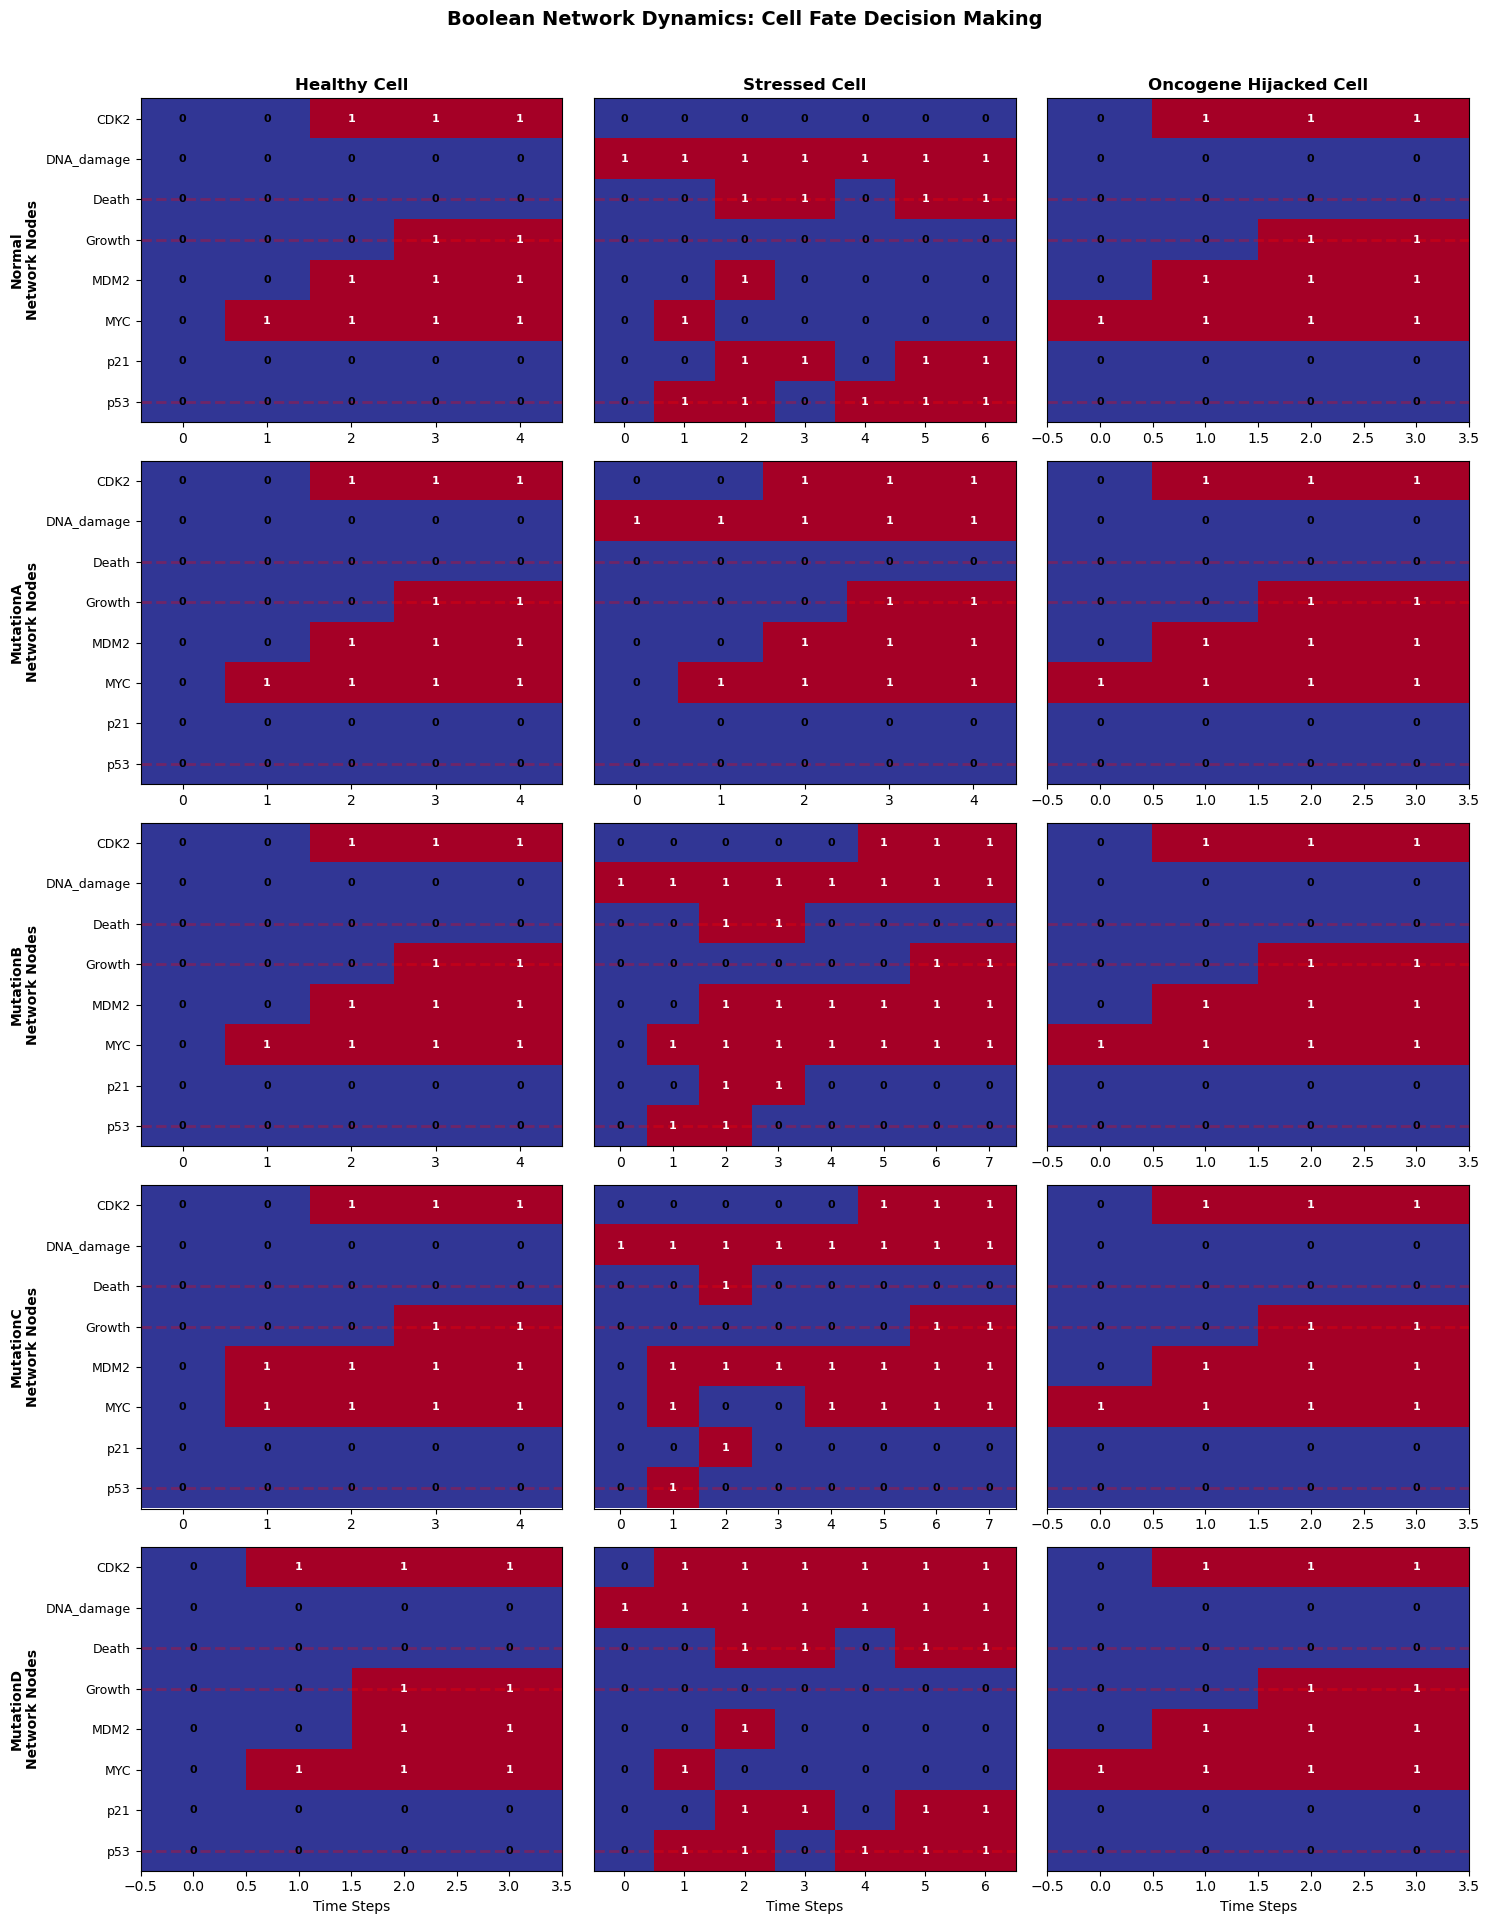

In [ ]:
scenario_order = ["Healthy Cell", "Stressed Cell", "Oncogene Hijacked Cell"]
network_order  = ["Normal", "MutationA", "MutationB", "MutationC", "MutationD"]

n_rows, n_cols = len(network_order), len(scenario_order)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 3.8*n_rows))

# Ensure axes is 2D
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = np.array([axes])
elif n_cols == 1:
    axes = axes[:, np.newaxis]

last_im = None

for r, net_name in enumerate(network_order):
    # Get node ordering for this network
    node_names = all_results[net_name]["node_names"]
    node_index = {n: i for i, n in enumerate(node_names)}

    for c, scenario_name in enumerate(scenario_order):
        ax = axes[r, c]

        trajectory = np.asarray(all_results[net_name]["trajectories"][scenario_name])
        trajectory_matrix = trajectory.T  # (nodes, time)

        last_im = ax.imshow(
            trajectory_matrix,
            cmap='RdYlBu_r',
            aspect='auto',
            interpolation='nearest',
            vmin=0, vmax=1
        )

        if r == 0:
            ax.set_title(f'{scenario_name}', fontweight='bold', fontsize=12)

        if c == 0:
            ax.set_ylabel(f'{net_name}\nNetwork Nodes', fontsize=10, fontweight='bold')
            ax.set_yticks(range(len(node_names)))
            ax.set_yticklabels(node_names, fontsize=9)
        else:
            ax.set_yticks([])
            ax.set_yticklabels([])

        if r == n_rows - 1:
            ax.set_xlabel('Time Steps', fontsize=10)

        T = trajectory.shape[0]
        N = len(node_names)
        for t in range(T):
            for n in range(N):
                val = int(trajectory_matrix[n, t])
                color = 'white' if val == 1 else 'black'
                ax.text(t, n, val, ha="center", va="center",
                        color=color, fontweight='bold', fontsize=8)

        for key_node in ['Growth', 'Death', 'p53']:
            if key_node in node_index:
                ax.axhline(y=node_index[key_node],
                           color='red', linestyle='--', alpha=0.3, linewidth=2)

plt.suptitle('Boolean Network Dynamics: Cell Fate Decision Making',
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()


## For each mutation (A, B, C, D) + normal network:

2) Attractor Analysis: Find all attractors for each mutated network (What percentage of states lead to cancer-like states?


================ Normal ================
Testing all 256 possible initial states...
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   

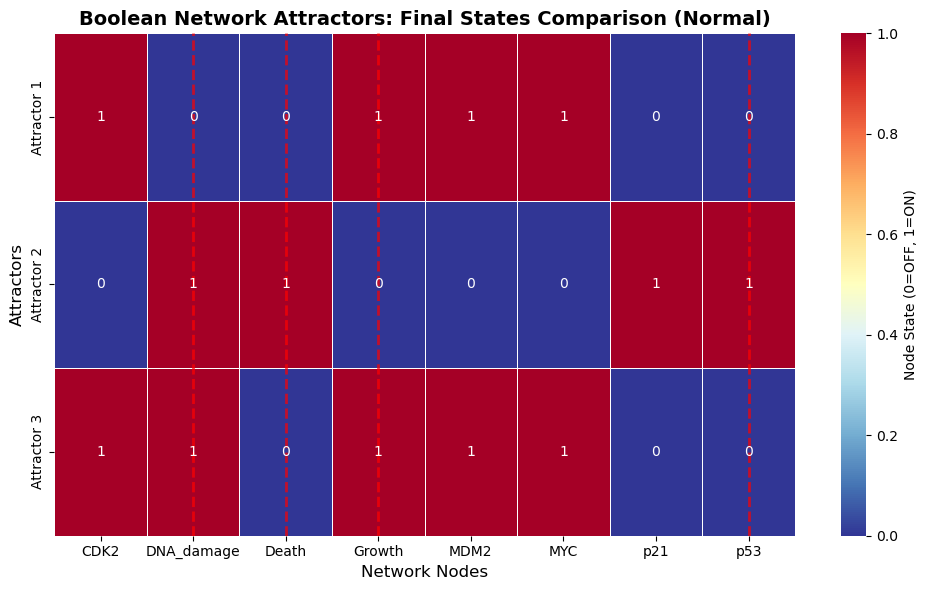


================ MutationA ================
Testing all 256 possible initial states...
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps


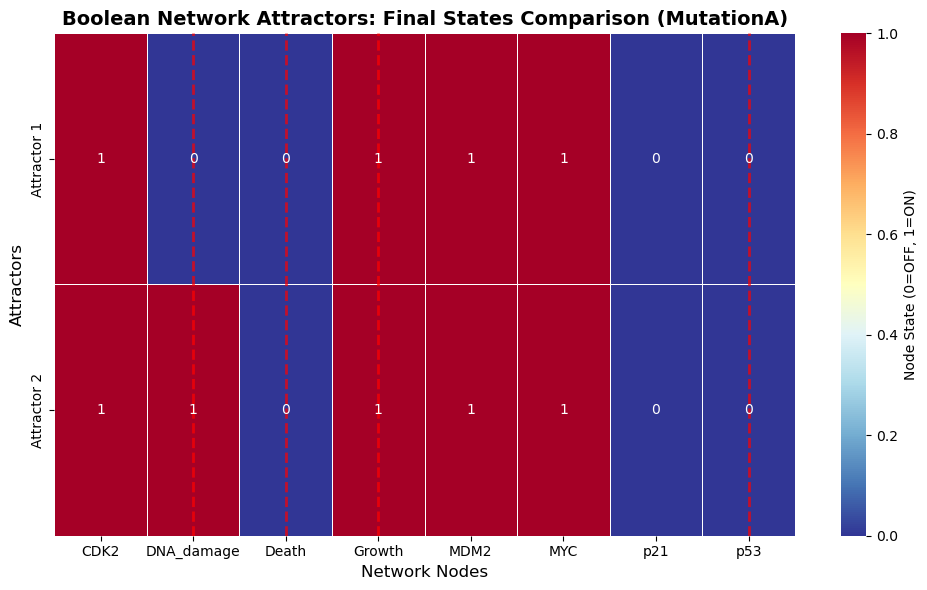


================ MutationB ================
Testing all 256 possible initial states...
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps


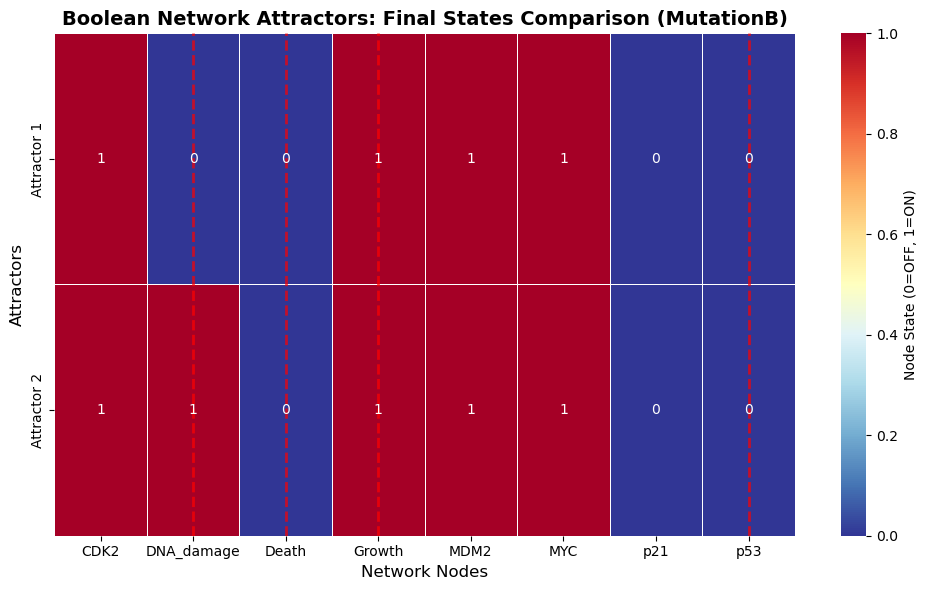


================ MutationC ================
Testing all 256 possible initial states...
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps


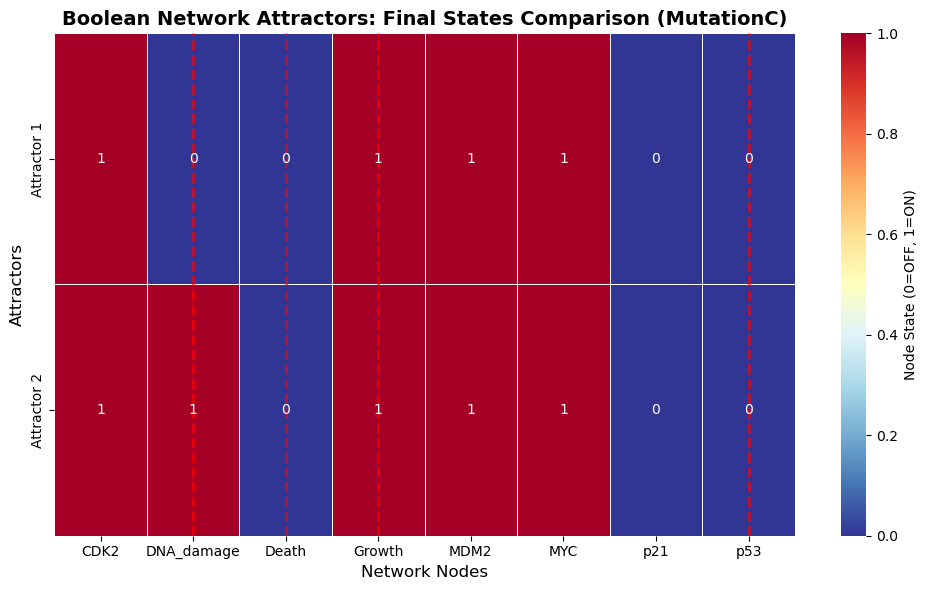


================ MutationD ================
Testing all 256 possible initial states...
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps


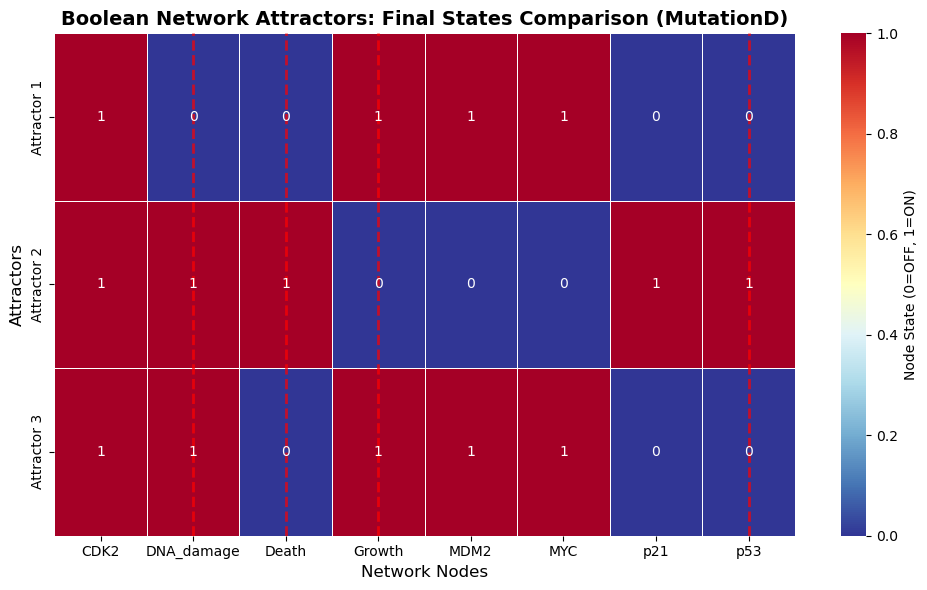

In [ ]:

networks = {
    "Normal":      networkNormal,
    "MutationA":   networkMutationA,
    "MutationB":   networkMutationB,
    "MutationC":   networkMutationC,
    "MutationD":   networkMutationD,
}

for net_name, network in networks.items():
    print(f"\n================ {net_name} ================")

    attractors = []
    max_steps = 15
    node_names = sorted(network.nodes.keys())
    n_nodes = len(node_names)

    print(f"Testing all {2**n_nodes} possible initial states...")
    all_states = list(product([0, 1], repeat=n_nodes))

    for initial_state in all_states:
        state_dict = {node_names[i]: initial_state[i] for i in range(n_nodes)}
        network.set_state(**state_dict)
        trajectory = network.simulate(steps=max_steps)

        if len(trajectory) >= 2 and np.array_equal(trajectory[-1], trajectory[-2]):
            final_state = tuple(int(x) for x in trajectory[-1])
            if final_state not in attractors:
                attractors.append(final_state)

    # 🟡 Let's find the attractor states (per network)
    print(f"\nFOUND {len(attractors)} ATTRACTORS:")

    for i, attractor in enumerate(attractors):
        print(f"\nAttractor {i+1}: {list(attractor)}")

        # Create state dictionary for easy access
        state_dict = {node_names[j]: attractor[j] for j in range(len(node_names))}

        # Analyze the biological meaning
        growth_active = state_dict.get('Growth', 0) == 1
        death_active = state_dict.get('Death', 0) == 1
        p53_active = state_dict.get('p53', 0) == 1
        dna_damage_active = state_dict.get('DNA_damage', 0) == 1

        print(f"   Growth: {'ON' if growth_active else 'OFF'}")
        print(f"   Death: {'ON' if death_active else 'OFF'}")
        print(f"   p53: {'ON' if p53_active else 'OFF'}")
        print(f"   DNA Damage: {'ON' if dna_damage_active else 'OFF'}")

        # Interpret the meaning
        if growth_active and not death_active and not dna_damage_active:
            interpretation = "Homeostatic proliferation (no damage response)"
        elif death_active and not growth_active:
            interpretation = "Stress/apoptotic state"
        elif growth_active and not death_active and dna_damage_active:
            interpretation = ("Pathologic: damage present but growth persists"
                              + (" (p53 OFF)" if not p53_active else " (check rules)"))
        else:
            interpretation = "CONFLICT - Unusual state"

        print(f"   → {interpretation}")

    # Convert attractors to clean matrix
    attractor_matrix = []
    for attractor in attractors:
        clean_row = [int(x) for x in attractor]
        attractor_matrix.append(clean_row)

    if len(attractor_matrix) == 0:
        print("No fixed-point attractors found.")
        continue

    attractor_matrix = np.array(attractor_matrix)

    # Create heatmap
    plt.figure(figsize=(10, max(6, len(attractors))))

    ax = sns.heatmap(attractor_matrix,
                     xticklabels=node_names,
                     yticklabels=[f'Attractor {i+1}' for i in range(len(attractors))],
                     cmap='RdYlBu_r',
                     cbar_kws={'label': 'Node State (0=OFF, 1=ON)'},
                     annot=True,
                     fmt='d',
                     linewidths=0.5)

    plt.title(f'Boolean Network Attractors: Final States Comparison ({net_name})',
              fontsize=14, fontweight='bold')
    plt.xlabel('Network Nodes', fontsize=12)
    plt.ylabel('Attractors', fontsize=12)

    # Highlight key output nodes
    output_nodes = ['Growth', 'Death', 'p53', 'DNA_damage']
    for node in output_nodes:
        if node in node_names:
            idx = node_names.index(node)
            ax.axvline(x=idx+0.5, color='red', linestyle='--', alpha=0.7, linewidth=2)

    plt.tight_layout()
    plt.show()



[Normal] Analyzing 256 initial states...
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reach

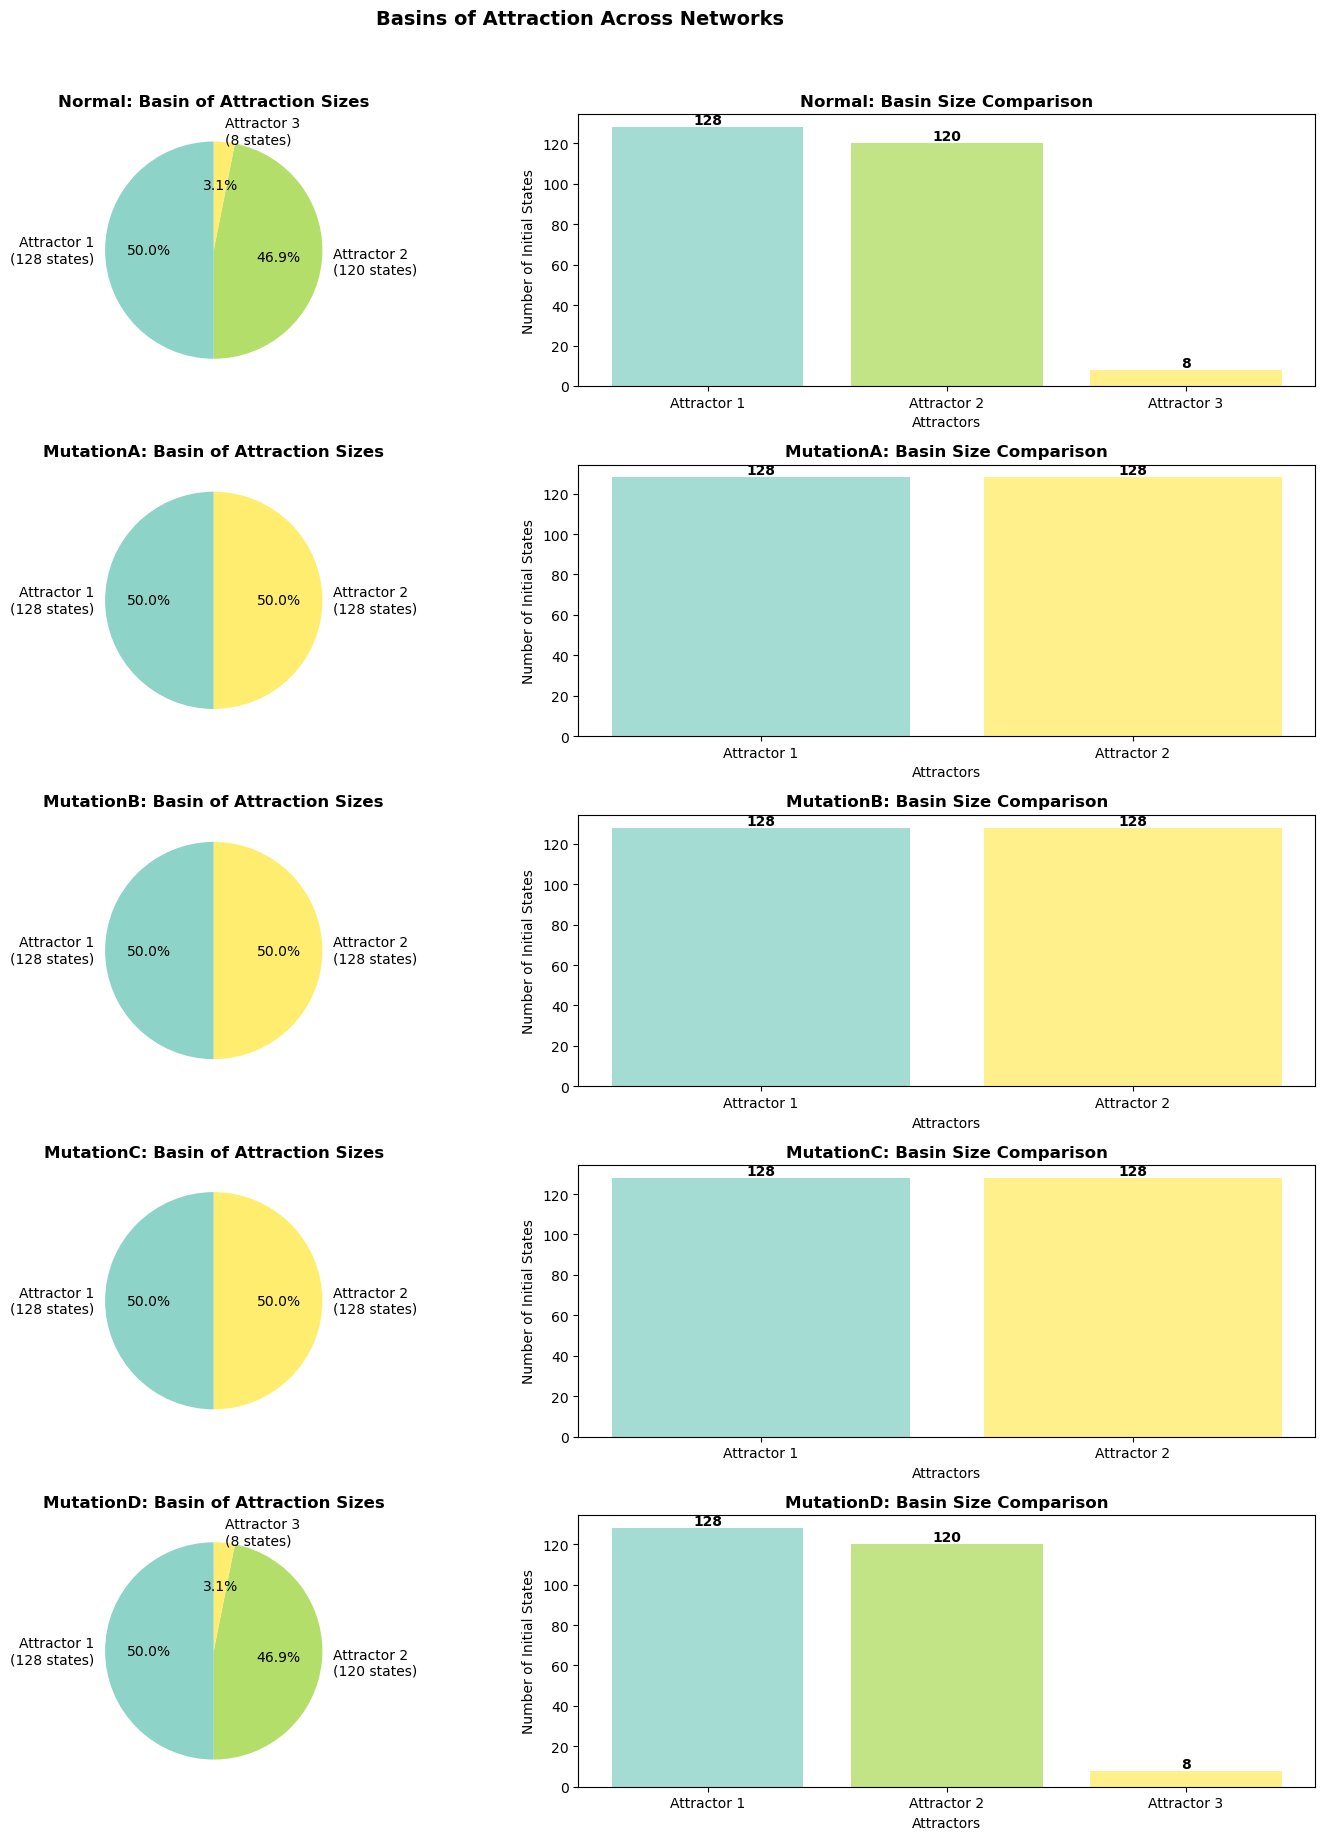

In [ ]:
networks = {
    "Normal":      networkNormal,
    "MutationA":   networkMutationA,
    "MutationB":   networkMutationB,
    "MutationC":   networkMutationC,
    "MutationD":   networkMutationD,
}

max_steps = 15

n_rows = len(networks)
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 3.6 * n_rows))
if n_rows == 1:
    axes = np.array([axes])

for row_idx, (net_name, network) in enumerate(networks.items()):
    node_names = sorted(network.nodes.keys())
    n_nodes = len(node_names)

    basin_data = defaultdict(list)
    attractor_map = {} 
    attractors = [] 

    all_states = list(product([0, 1], repeat=n_nodes))
    total_states = len(all_states)
    print(f"\n[{net_name}] Analyzing {total_states} initial states...")

    for initial_state in all_states:
        state_dict = {node_names[i]: initial_state[i] for i in range(n_nodes)}
        network.set_state(**state_dict)

        trajectory = network.simulate(steps=max_steps, record_history=True)

        if len(trajectory) >= 2 and np.array_equal(trajectory[-1], trajectory[-2]):
            final_state = tuple(int(x) for x in trajectory[-1])

            try:
                att_idx = attractors.index(final_state)
            except ValueError:
                attractors.append(final_state)
                att_idx = len(attractors) - 1

            basin_data[att_idx].append(initial_state)
            attractor_map[initial_state] = att_idx

    print(f" Basin Sizes ({net_name}):")
    for att_idx in range(len(attractors)):
        basin_size = len(basin_data[att_idx])
        percentage = (basin_size / total_states) * 100
        print(f"   Attractor {att_idx+1}: {basin_size:3d} states ({percentage:5.1f}%)")

    ax1 = axes[row_idx, 0]
    ax2 = axes[row_idx, 1]

    if len(attractors) == 0:
        ax1.axis('off'); ax2.axis('off')
        ax1.set_title(f'{net_name}: No fixed-point attractors found', fontweight='bold')
        continue

    basin_sizes = [len(basin_data[i]) for i in range(len(attractors))]
    basin_labels = [f'Attractor {i+1}\n({size} states)' for i, size in enumerate(basin_sizes)]
    colors = plt.cm.Set3(np.linspace(0, 1, len(attractors)))

    ax1.pie(
        basin_sizes,
        labels=basin_labels,
        colors=colors,
        autopct='%1.1f%%',
        startangle=90
    )
    ax1.set_title(f'{net_name}: Basin of Attraction Sizes', fontsize=12, fontweight='bold')

    attractor_names = [f'Attractor {i+1}' for i in range(len(attractors))]
    bars = ax2.bar(attractor_names, basin_sizes, color=colors, alpha=0.8)
    ax2.set_title(f'{net_name}: Basin Size Comparison', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Number of Initial States', fontsize=10)
    ax2.set_xlabel('Attractors', fontsize=10)
    for bar, size in zip(bars, basin_sizes):
        h = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., h, f'{size}',
                 ha='center', va='bottom', fontweight='bold')

plt.suptitle('Basins of Attraction Across Networks', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


### Cancer-like states

Growth = 1 & Death = 0 & DNA-damage = 1 

   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached s

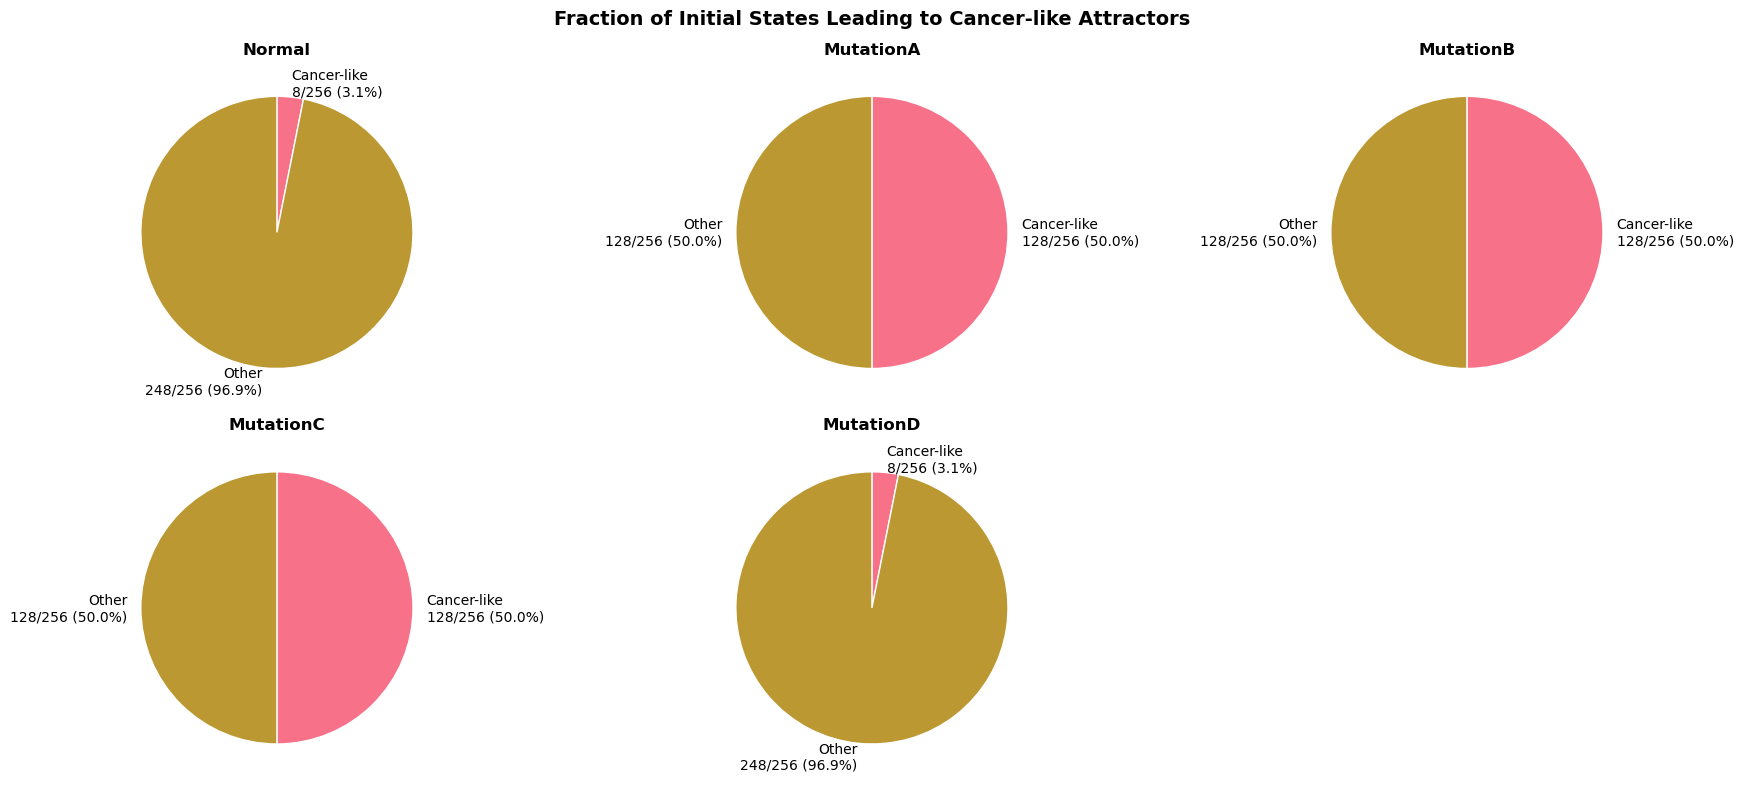

In [15]:

def count_cancer_like_initial_states(network, max_steps=15):
    node_names = sorted(network.nodes.keys())
    n = len(node_names)
    total = 2**n
    cancer_count = 0

    for state in product([0, 1], repeat=n):
        network.set_state(**{node_names[i]: state[i] for i in range(n)})
        traj = network.simulate(steps=max_steps)

        if len(traj) >= 2 and np.array_equal(traj[-1], traj[-2]):
            final = {node_names[i]: int(traj[-1][i]) for i in range(n)}
            if (final.get('Growth', 0) == 1 and final.get('Death', 0) == 0 and
                final.get('DNA_damage', 0) == 1 and final.get('p53', 0) == 0):
                cancer_count += 1
    return cancer_count, total

networks = {
    "Normal":      networkNormal,
    "MutationA":   networkMutationA,
    "MutationB":   networkMutationB,
    "MutationC":   networkMutationC,
    "MutationD":   networkMutationD,
}
counts = {}
for name, net in networks.items():
    c, total = count_cancer_like_initial_states(net, max_steps=15)
    counts[name] = (c, total - c, total)

# plot 5 pies
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.ravel()

for i, (name, (cancer, other, total)) in enumerate(counts.items()):
    sizes = [cancer, other]
    labels = [f'Cancer-like\n{cancer}/{total} ({100*cancer/total:.1f}%)',
              f'Other\n{other}/{total} ({100*other/total:.1f}%)']
    axes[i].pie(
        sizes, labels=labels, startangle=90, counterclock=False,
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'}, autopct=None
    )
    axes[i].set_title(name, fontweight='bold')
axes[-1].axis('off')

plt.suptitle('Fraction of Initial States Leading to Cancer-like Attractors', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
